In [1]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
 
plt.rcParams.update({'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [2]:
import copy

In [3]:
print(tf.__version__)

2.2.0


In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [6]:
DATA_PATH = '/global/cscratch1/sd/vboehm/embeddings'

emb = np.load(os.path.join(DATA_PATH,'resonance_embeddings.npy'))

In [7]:
non_zero_dims = []
for ii in range(16):
    if len(np.where(emb[:,ii]!=0.)[0])>0:
        non_zero_dims.append(ii)
        
print(non_zero_dims)

[4, 6, 11, 15]


In [8]:
params={}
params['latent_size']=len(non_zero_dims)
params['embedding_size'] = emb.shape[-1]

In [50]:
nvp_depth    = 6
dims         = np.asarray([4,4,4,4,4,4])
nvp_size     = np.arange(nvp_depth)
indices      = np.arange(len(non_zero_dims))

In [51]:
def get_prior(latent_size):
    return tfd.MultivariateNormalDiag(tf.zeros(latent_size), scale_identity_multiplier=1.0)

In [52]:

# class Logit(tfb.Bijector):

#     def __init__(self, validate_args=True, name='logit'):
#         super(Logit, self).__init__(validate_args=validate_args,
#         name=name,forward_min_event_ndims=0)

        
#         self.sigmoid = tfb.Sigmoid(validate_args=True)

#     def _forward(self, x):
#         return self.sigmoid.inverse(x+1e-4)+5

#     def _inverse(self, y):
#         return self.sigmoid.forward(y-5)-1e-4

#     def _inverse_log_det_jacobian(self, y):
#         return self.sigmoid.forward_log_det_jacobian(y)

#     def _forward_log_det_jacobian(self, x):
#         return self.sigmoid.inverse_log_det_jacobian(y)


In [53]:
def trainable_lu_factorization(
    event_size, batch_shape=(), seed=None, dtype=tf.float32, name=None):
    with tf.name_scope(name or 'trainable_lu_factorization'):
        event_size = tf.convert_to_tensor(
            event_size, dtype_hint=tf.int32, name='event_size')
        batch_shape = tf.convert_to_tensor(
            batch_shape, dtype_hint=event_size.dtype, name='batch_shape')
        random_matrix = tf.random.uniform(
            shape=tf.concat([batch_shape, [event_size, event_size]], axis=0),
            dtype=dtype,
            seed=seed)
        random_orthonormal = tf.linalg.qr(random_matrix)[0]
        lower_upper, permutation = tf.linalg.lu(random_orthonormal)
        lower_upper = tf.Variable(
            initial_value=lower_upper,
            trainable=True,
            name='lower_upper')
        # Initialize a non-trainable variable for the permutation indices so
        # that its value isn't re-sampled from run-to-run.
        permutation = tf.Variable(
            initial_value=permutation,
            trainable=False,
            name='permutation')
        return lower_upper, permutation


In [54]:
class SplineParams(tf.Module):

    def __init__(self, nunits, nbins=32):
        self._nbins = nbins
        self._nunits= nunits
        self._built = False
        self._bin_widths = None
        self._bin_heights = None
        self._knot_slopes = None

    def _bin_positions(self, x):
        x = tf.reshape(x, [-1,self._nunits,self._nbins])
        net = tf.layers.Dense(self._nunits)(x)
        net = tf.nn.leaky_relu(net)
        net = tf.layers.Dense(self._nunits)(net)
        net = tf.nn.leaky_relu(net)
        net = tf.layers.Dense(self._nbins)(net)
        net = tf.reshape(net, [-1,self._nunits, self._nbins])
        return tf.math.softmax(net, axis=-1) * (2 - self._nbins * 1e-2) + 1e-2

    def _slopes(self, x):
        x = tf.reshape(x, [-1,  self._nunits, ( self._nbins - 1)])
#         net = tf.layers.Dense(self._nunits)(x)
#         net = tf.nn.leaky_relu(net)
#         net = tf.layers.Dense(self._nbins-1)(net)
#         net = tf.reshape(net, [-1,  self._nunits, ( self._nbins - 1)])
        return tf.math.softplus(x) + 1e-2

    def __call__(self, x, nunits):

        bin_positions = self._bin_positions
        if not self._built:
            self._bin_widths  = tf.layers.Dense(self._nunits * self._nbins, activation=bin_positions, name='w')
            self._bin_heights = tf.layers.Dense(self._nunits * self._nbins, activation=bin_positions, name='h')
            self._knot_slopes = tf.layers.Dense(self._nunits * (self._nbins - 1), activation=self._slopes, name='s')
        self._built = True
        result = tfb.RationalQuadraticSpline(bin_widths=self._bin_widths(x),bin_heights=self._bin_heights(x),knot_slopes=self._knot_slopes(x))
        
        return result

In [55]:
tf.reset_default_graph()

lr            = tf.placeholder_with_default(0.001,shape=[])
data          = tf.placeholder(shape=[None,params['embedding_size']],dtype=tf.float32)
bs            = tf.placeholder_with_default(16,shape=[])

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)
prior         = get_prior(params['latent_size'])

def init_once(x, name):
    return tf.get_variable(name, initializer=x, trainable=False)



def get_nvp():
    chain             = []
    reduction         = (params['latent_size']-dims)/params['latent_size']
    current_size      = []
    perms_swap        = []
    perms_rand        = []
    perms_train       = []
    splines           = []
    size              = []
    #current_size      = params['latent_size']
    for i,s in enumerate(nvp_size):
        current_size  = np.int(params['latent_size']*(1-reduction[i]))
        swapping      = np.concatenate((np.arange(current_size//2,current_size),np.arange(0, current_size//2)))
        perms_swap.append(tfb.Permute(permutation=init_once(swapping,name="perm_swap%d"%i)))
        permutation   = np.random.permutation(np.arange(0, current_size))
        perms_rand.append(tfb.Permute(permutation=init_once(permutation,name="perm_rand%d"%i)))
        perms_train.append(tfb.MatvecLU(*trainable_lu_factorization(current_size),validate_args=True, name="perms_train%d"%i))
        splines.append(SplineParams(current_size//2))
        size.append(current_size)
        print(current_size, size)
    
    
#     chain.append(tfb.Scale(0.2))
    for i,s in enumerate(nvp_size):
        if i%2==0:
            chain.append(tfb.Blockwise(bijectors=[perms_train[i],tfb.Identity()],block_sizes=[size[i],params['latent_size']-size[i]]))
        else:
            chain.append(tfb.Blockwise(bijectors=[perms_swap[i],tfb.Identity()],block_sizes=[size[i],params['latent_size']-size[i]]))
        if i<2: 
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,bijector_fn=splines[i])
        if i<8 and i>4:
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[params['latent_size'],params['latent_size']]))                 
        else:
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[params['latent_size'],params['latent_size']],shift_only=True))  
        bijector2 = tfb.Identity()
        chain.append(tfb.Blockwise(bijectors=[bijector1, bijector2], block_sizes=[size[i],params['latent_size']-size[i]]))
    chain.append(tfb.Scale(5))
#    chain.append(Logit())
    
    # p(x) is Gaussian, chain: y=g(x)
    # bwd goes from last to first in the chain (inverse)
    nvp=tfd.TransformedDistribution(distribution=tfd.Normal(0,1),bijector=tfb.Chain(chain),name='mynvp', event_shape=(params['latent_size'],))
                 
    return nvp

def nvp_module_spec():
    z_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    sample_size  = tf.placeholder(tf.int32, shape=[])
    u_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    nvp_         = get_nvp()
    log_prob     = nvp_.log_prob(z_sample)
    nvp_sample   = nvp_.sample(sample_size)
    nvp_fwd_pass = nvp_.bijector.forward(u_sample)
    nvp_bwd_pass = nvp_.bijector.inverse(z_sample)
    hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample}\
                      ,outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass, 'bwd_pass': nvp_bwd_pass})

nvp_spec  = hub.create_module_spec(nvp_module_spec)
#nvp_funcs = hub.Module(nvp_path, trainable=True)#
nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)
comp_data      = tf.gather(data,non_zero_dims,axis=1)
comp_data_log  = tfb.Sigmoid(low=0, high=1.0).inverse(comp_data+1e-4)+5
loss           = -tf.reduce_mean(nvp_funcs({'z_sample':comp_data_log,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['log_prob'])
bwd            = nvp_funcs({'z_sample':comp_data_log,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['bwd_pass']

prior_sample   = prior.sample(bs)
sample         = nvp_funcs({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':prior_sample},as_dict=True)['fwd_pass']
opt_op_nvp = optimizer.minimize(loss)


4 [4]
4 [4, 4]
4 [4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4, 4]
4 [4, 4, 4, 4, 4, 4]
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [56]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [57]:
comp_emb_log, comp_emb, bwd = sess.run([comp_data_log, comp_data, bwd], feed_dict={data:emb})

In [58]:
print(max(comp_emb.flatten()), min(comp_emb.flatten()))
print(max(comp_emb_log.flatten()), min(comp_emb_log.flatten()))
print(max(bwd.flatten()), min(bwd.flatten()), np.mean(bwd))

0.07874791 0.0
2.5418956 -4.2102404
1.6291131 -0.90413284 0.06392939


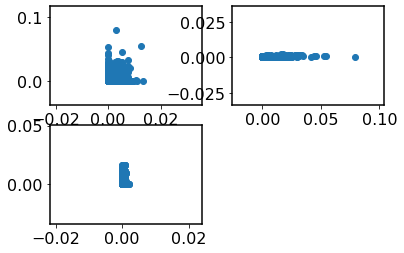

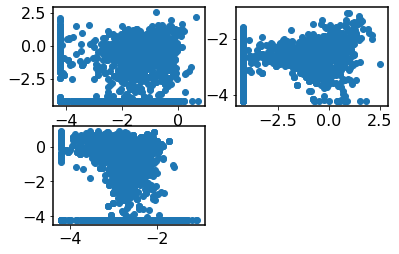

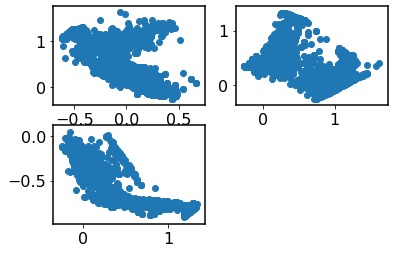

In [59]:
for ii in range(params['latent_size']-1):
    plt.subplot(2,2, ii+1)
    plt.scatter(comp_emb[:,ii],comp_emb[:,ii+1])
plt.show()   
for ii in range(params['latent_size']-1):
    plt.subplot(2,2, ii+1)
    plt.scatter(comp_emb_log[:,ii],comp_emb_log[:,ii+1])
plt.show()
for ii in range(params['latent_size']-1):
    plt.subplot(2,2, ii+1)
    plt.scatter(bwd[:,ii],bwd[:,ii+1])

In [60]:
learning_rate = 1e-3
sess.run([opt_op_nvp,loss],  feed_dict={lr: learning_rate, data:emb})

[None, 10.827103]

In [61]:
nvp_tloss = []
nvp_vloss = []
ii     = 0

In [69]:
learning_rate = 1e-2
batchsize = 8
train_size = len(emb)
epoch = len(emb)//batchsize
train_size = int(len(emb)/6*5)
print(train_size)
z_sample = emb[:train_size]
z_sample_valid = emb[train_size:,] 
valid_size = len(z_sample_valid)
z_sample_train = z_sample[:]
n_epochs = 350
break_count =0
while ii<n_epochs:
    print('epoch ', ii)
    jj = 0
    if ii>10:
        batchsize = 16
        learning_rate = 1e-3
    if ii>30:
        batchsize = 32
    if ii>40:
        learning_rate=1e-4
    if ii>60:
        batch_size=16
    if ii>180:
        batch_size=8
    if ii>200:
        batch_size=16
    if ii>250:
        learning_rate=1e-3
    if ii>300:
        learning_rate=1e-4    
    if ii>330:
        batch_size=32
    epoch = train_size//batchsize
    while jj<epoch:
        noise= 0.#np.abs(np.random.randn(batchsize,params['embedding_size'])*1e-6)
        _, ll = sess.run([opt_op_nvp,loss],  feed_dict={lr: learning_rate, data:z_sample_train[jj*batchsize:(jj+1)*batchsize]+noise})
        if jj%200==0 and ii%2==0:
            np.random.shuffle(z_sample_valid)
            l_v = sess.run(loss,  feed_dict={lr: learning_rate,lr: learning_rate,data:z_sample_valid})
            nvp_vloss+=[l_v]
            inds = np.random.randint(low=0, high=train_size, size=1024)
            l_t = sess.run(loss,  feed_dict={lr: learning_rate,lr: learning_rate,data:z_sample[inds]})
            nvp_tloss+=[l_t]
            print(l_t, l_v)
            if l_v<l_t:
                break_count+=1.
            if l_t>l_v:
                break_count=0.
#             sample = sess.run(fwd_pass)
#             print(np.amax(sample))
#         if jj==0:
#             nn = np.random.randint(low=0,high=63)
#             plt.scatter(z_sample_valid[:500,nn],z_sample_valid[:500,nn+1],s=1, label='encoded data valid')
#             plt.scatter(z_sample[:500,nn],z_sample[:500,nn+1],s=2, label='encoded data') 
#             plt.scatter(latent_samples[:500,nn],latent_samples[:500,nn+1],s=2, label='RealNVP samples') 
#             plt.show()
        if break_count>100:
            break
        jj+=1
#     if ii%10==0 and ii>0:
#         nvp_path         = os.path.join(params['module_dir'],'hybrid8_nepoch%d'%ii)
#         try:
#             nvp_funcs.export(nvp_path,sess)
#         except:
#             pass
    np.random.shuffle(z_sample) 
    if ii%100==0 and ii != 0:
        z_ = copy.copy(z_sample_valid)
        z_sample_valid = copy.copy(z_sample[0:valid_size])
        z_sample[0:valid_size] = z_

    z_sample_train = copy.copy(z_sample)
    ii+=1

3000
epoch  186
-0.32431477 -1.4323114
epoch  187
epoch  188
-0.45639372 -1.4666654
epoch  189
epoch  190
-0.08510629 -1.4730947
epoch  191
epoch  192
-0.605616 -1.5041342
epoch  193
epoch  194
-0.20300475 -1.3477482
epoch  195
epoch  196
-0.24749824 -1.4671324
epoch  197
epoch  198
-0.50875235 -1.3959821
epoch  199
epoch  200
-0.19165106 -1.3684928
epoch  201
epoch  202
-0.7753173 -0.14796901
epoch  203
epoch  204
-1.0923299 -0.18859866
epoch  205
epoch  206
6.060953 8.262178
epoch  207
epoch  208
3.868149 3.5133033
epoch  209
epoch  210
-0.2599713 0.02028924
epoch  211
epoch  212
-0.53087705 0.044332605
epoch  213
epoch  214
-0.7330888 0.036010545
epoch  215
epoch  216
-0.7398766 0.032980174
epoch  217
epoch  218
-0.42069674 -0.01850023
epoch  219
epoch  220
-0.76604056 0.03569408
epoch  221
epoch  222
-0.39063114 0.08840163
epoch  223
epoch  224
-0.68471146 0.035519086
epoch  225
epoch  226
-0.52901626 -0.099674545
epoch  227
epoch  228
-0.4529514 0.05663476
epoch  229
epoch  230
-0

KeyboardInterrupt: 

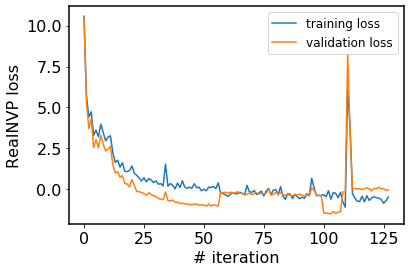

In [70]:
plt.figure()
plt.plot(nvp_tloss,label='training loss')
plt.plot(nvp_vloss,label='validation loss' )
plt.xlabel('# iteration')
plt.ylabel('RealNVP loss')
plt.legend()

In [64]:
bwd_train = sess.run(nvp_funcs({'z_sample':comp_data_log,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['bwd_pass'],  feed_dict={data:z_sample})
bwd_valid = sess.run(nvp_funcs({'z_sample':comp_data_log,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['bwd_pass'],  feed_dict={data:z_sample_valid})
prior_sample = sess.run(prior_sample,  feed_dict={bs:len(z_sample)})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


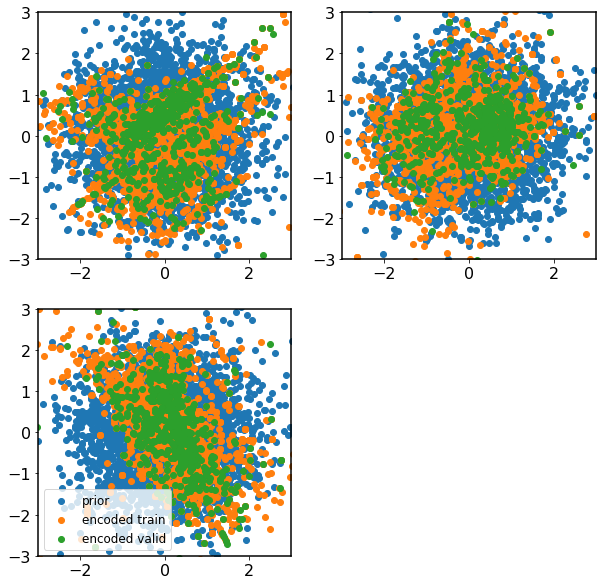

In [65]:
plt.figure(figsize=(10,10))
for nn in range(params['latent_size']-1):
    plt.subplot(2,2, nn+1)
    plt.scatter(prior_sample[:,nn],prior_sample[:,nn+1], label='prior')
    plt.scatter(bwd_train[:,nn],bwd_train[:,nn+1],label='encoded train')
    plt.scatter(bwd_valid[:,nn],bwd_valid[:,nn+1], label='encoded valid')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
plt.legend()
plt.show()

In [66]:
fwd_sample = sess.run(sample, feed_dict={bs:len(z_sample)})

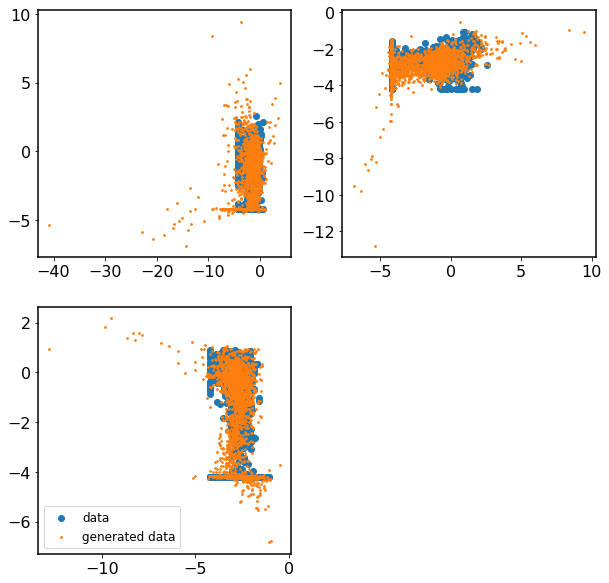

In [67]:
plt.figure(figsize=(10,10))
for nn in range(params['latent_size']-1):
    plt.subplot(2,2, nn+1)
    plt.scatter(comp_emb_log[:,nn],comp_emb_log[:,nn+1], label='data')
    plt.scatter(fwd_sample[:,nn],fwd_sample[:,nn+1],s=3, label='generated data')
plt.legend()